In [7]:
import numpy as np

from pathlib import Path
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from collections import Counter
import numpy as np
import os
import sys
import textdistance
import json
from pprint import pprint

try:
    from synoracle import ingredients, sequence
except ModuleNotFoundError:
    module_path = os.path.abspath(os.path.join('c:\\Users\\d23895jm\\Desktop\\Work master 2022\\Active research Projects\\synoracle_publication\\SyntheticOracle'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from synoracle import ingredients, sequence

try:
    from synparagraph import SynParagraph
except ModuleNotFoundError:
    module_path = os.path.abspath(os.path.join('c:\\Users\\d23895jm\\Desktop\\Work master 2022\\Active research Projects\\synoracle-preprocessing\\synoracle'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from synparagraph import SynParagraph

from tqdm.notebook import tqdm, trange

def li_iterate(li):
    l = iter(li)
    for _ in trange(len(li)):
        yield next(l)

In [8]:
manual_sequences = pd.read_csv('D:/nist_manual_sequences.csv')

unit_converter = {
    'L': 'volume',
    'mL': 'volume',
    'drops': 'volume',
    'g': 'mass',
    'mg': 'mass',
    'mmol': 'other_amount',
    'nan':np.nan,
    np.nan:np.nan
}

for c,x in manual_sequences.iterrows():
    new_chemicals = []
    try:
        str(eval(x['chemicals and amount sued']))
    except TypeError:
        # print(c, x['chemicals and amount sued'])
        pass
    else:
        try:
            eval(x['chemicals and amount sued']).items()
        except AttributeError:
            pass
        else:
            for y in eval(x['chemicals and amount sued']).items():
                # print(y)
                if len(y[1].split(' ')) >1:
                    #print(unit_converter[y[1].split(' ')[1]])
                    new_chemicals.append({'name': y[0], unit_converter[y[1].split(' ')[1]]: y[1]})
                else:
                    new_chemicals.append({'name': y[0]})
    manual_sequences.loc[c, 'new_chemicals'] = str(new_chemicals)
manual_sequences['identifier'] = manual_sequences['Paper'] + '.' + manual_sequences['Paragraph'].astype(str)    
manual_sequences['time'] = manual_sequences['time'].astype(str)
manual_sequences['temp'] = manual_sequences['temp'].astype(str)
manual_sequences['time']

0            []
1            []
2            []
3      ['24 h']
4            []
         ...   
456          []
457          []
458          []
459          []
460          []
Name: time, Length: 461, dtype: object

In [9]:
with open('../NIST sequences.json', 'r') as f:
    raw_gpt = json.load(f)
    gpt_dfs = [pd.DataFrame(x) for x in raw_gpt]

gpt_sequences = {x['paper'].unique()[0] + '.' + x['paragraph'].unique()[0]: x for x in gpt_dfs}

In [10]:
source_dir = Path(r"D:/NIST-ZIF-8")
similarity_info = {}
for x in manual_sequences['identifier'].unique():
    print(f'{x}\n--------------')
    manual = sequence.Sequence(manual_sequences[manual_sequences['identifier']==x].reset_index(drop=True))
    manual.extract_chemicals()
    manual.extract_conditions()
    manual.condense_to_supertypes()
    manual_s = Counter(manual.clean_synthesis['name'])
    manual_cs = Counter(manual.condensed_sequence.index)

    cde_paragraph = SynParagraph(paper_identifier=x, source_directory=source_dir)
    cde_sequence = sequence.Sequence(cde_paragraph.raw_synthesis)
    cde_sequence.drop_invalid_lines()
    cde_sequence.extract_chemicals()
    cde_sequence.extract_conditions()
    cde_sequence.condense_to_supertypes()
    cde_s = Counter(cde_sequence.clean_synthesis['name'])
    #cde_s = Counter(manual.clean_synthesis['name'])
    cde_s_prec = sum((cde_s & manual_s).values())/sum(cde_s.values())
    cde_s_recall = sum((cde_s & manual_s).values())/sum(manual_s.values())
    cde_s_f1 = 2*cde_s_prec*cde_s_recall/(cde_s_prec+cde_s_recall)

    cde_cs = Counter(cde_sequence.condensed_sequence.index)
    cde_cs_prec = sum((cde_cs & manual_cs).values())/sum(cde_cs.values())
    cde_cs_recall = sum((cde_cs & manual_cs).values())/sum(manual_cs.values())
    cde_cs_f1 = 2*cde_cs_prec*cde_cs_recall/(cde_cs_prec+cde_cs_recall)

    gpt = sequence.Sequence(gpt_sequences[x])
    gpt.drop_invalid_lines()
    gpt.extract_chemicals()
    gpt.extract_conditions()   
    gpt.condense_to_supertypes()
    gpt_s = Counter(cde_sequence.clean_synthesis['name'])
    #gpt_s = Counter(manual.clean_synthesis['name'])
    gpt_s_prec = sum((cde_s & manual_s).values())/sum(cde_s.values())
    gpt_s_recall = sum((cde_s & manual_s).values())/sum(manual_s.values())
    gpt_s_f1 = 2*gpt_s_prec*gpt_s_recall/(gpt_s_prec+gpt_s_recall)


    gpt_cs = Counter(gpt.condensed_sequence.index)
    gpt_cs_prec = sum((gpt_cs & manual_cs).values())/sum(gpt_cs.values())
    gpt_cs_recall = sum((gpt_cs & manual_cs).values())/sum(manual_cs.values())
    gpt_cs_f1 = 2*gpt_cs_prec*gpt_cs_recall/(gpt_cs_prec+gpt_cs_recall)


    similarity_info[x] = {
        'manual_temp_values': len(manual.conditions.temps),
        'cde_temp_values': len(cde_sequence.conditions.temps),
        'gpt_temp_values': len(gpt.conditions.temps),
        'cde_temp_sim': manual.conditions._temp_similarity(cde_sequence.conditions),
        'gpt_temp_sim': manual.conditions._temp_similarity(gpt.conditions),
        'manual_time_values': len(manual.conditions.times),
        'cde_time_values': len(cde_sequence.conditions.times),
        'gpt_time_values': len(gpt.conditions.times),
        'cde_time_sim': manual.conditions._time_similarity(cde_sequence.conditions),
        'gpt_time_sim': manual.conditions._time_similarity(gpt.conditions),

        'manual_sequence': len(manual.clean_synthesis['name'].to_list()),
        'cde_sequence': len(cde_sequence.clean_synthesis['name'].to_list()),
        'gpt_sequence': len(gpt.clean_synthesis['name'].to_list()),
        'cde_s_prec': 100*cde_s_prec,
        'cde_s_recall': 100*cde_s_recall,
        'cde_s_f1': 100*cde_s_f1,
        'gpt_s_prec': 100*gpt_s_prec,
        'gpt_s_recall': 100*gpt_s_recall,
        'gpt_s_f1': 100*gpt_s_f1,        
        'cde_sequence_sim': round(textdistance.levenshtein.normalized_similarity(manual.clean_synthesis['name'].to_list(), cde_sequence.clean_synthesis['name'].to_list()),3),
        'gpt_sequence_sim': round(textdistance.levenshtein.normalized_similarity(manual.clean_synthesis['name'].to_list(), gpt.clean_synthesis['name'].to_list()),3), 

        'manual_condensed_sequence': len(manual.condensed_sequence),
        'cde_condensed_sequence': len(cde_sequence.condensed_sequence),
        'gpt_condensed_sequence': len(gpt.condensed_sequence),
        'cde_cs_prec': 100*cde_cs_prec,
        'cde_cs_recall': 100*cde_cs_recall,
        'cde_cs_f1': 100*cde_cs_f1,
        'gpt_cs_prec': 100*gpt_cs_prec,
        'gpt_cs_recall': 100*gpt_cs_recall,
        'gpt_cs_f1': 100*gpt_cs_f1,   
        'cde_condensed_sequence_sim': round(textdistance.levenshtein.normalized_similarity(manual.condensed_sequence.index.to_list(), cde_sequence.condensed_sequence.index.to_list()),3),
        'gpt_condensed_sequence_sim': round(textdistance.levenshtein.normalized_similarity(manual.condensed_sequence.index.to_list(), gpt.condensed_sequence.index.to_list()),3),         
    }

    pprint(similarity_info[x])


009589722013797966.16
--------------


{'cde_condensed_sequence': 4,
 'cde_condensed_sequence_sim': 0.25,
 'cde_cs_f1': 85.71428571428571,
 'cde_cs_prec': 75.0,
 'cde_cs_recall': 100.0,
 'cde_s_f1': 38.095238095238095,
 'cde_s_prec': 28.57142857142857,
 'cde_s_recall': 57.14285714285714,
 'cde_sequence': 14,
 'cde_sequence_sim': 0.286,
 'cde_temp_sim': 100.0,
 'cde_temp_values': 2,
 'cde_time_sim': 100.0,
 'cde_time_values': 1,
 'gpt_condensed_sequence': 4,
 'gpt_condensed_sequence_sim': 0.25,
 'gpt_cs_f1': 85.71428571428571,
 'gpt_cs_prec': 75.0,
 'gpt_cs_recall': 100.0,
 'gpt_s_f1': 38.095238095238095,
 'gpt_s_prec': 28.57142857142857,
 'gpt_s_recall': 57.14285714285714,
 'gpt_sequence': 11,
 'gpt_sequence_sim': 0.364,
 'gpt_temp_sim': 100.0,
 'gpt_temp_values': 2,
 'gpt_time_sim': 100.0,
 'gpt_time_values': 1,
 'manual_condensed_sequence': 3,
 'manual_sequence': 7,
 'manual_temp_values': 2,
 'manual_time_values': 1}
Aic13970.6
--------------


{'cde_condensed_sequence': 6,
 'cde_condensed_sequence_sim': 0.667,
 'cde_cs_f1': 80.0,
 'cde_cs_prec': 66.66666666666666,
 'cde_cs_recall': 100.0,
 'cde_s_f1': 44.44444444444445,
 'cde_s_prec': 40.0,
 'cde_s_recall': 50.0,
 'cde_sequence': 15,
 'cde_sequence_sim': 0.333,
 'cde_temp_sim': 100.0,
 'cde_temp_values': 4,
 'cde_time_sim': 100.0,
 'cde_time_values': 2,
 'gpt_condensed_sequence': 6,
 'gpt_condensed_sequence_sim': 0.667,
 'gpt_cs_f1': 80.0,
 'gpt_cs_prec': 66.66666666666666,
 'gpt_cs_recall': 100.0,
 'gpt_s_f1': 44.44444444444445,
 'gpt_s_prec': 40.0,
 'gpt_s_recall': 50.0,
 'gpt_sequence': 13,
 'gpt_sequence_sim': 0.385,
 'gpt_temp_sim': 100.0,
 'gpt_temp_values': 4,
 'gpt_time_sim': 100.0,
 'gpt_time_values': 2,
 'manual_condensed_sequence': 4,
 'manual_sequence': 12,
 'manual_temp_values': 3,
 'manual_time_values': 2}
Aic13970.7
--------------


{'cde_condensed_sequence': 4,
 'cde_condensed_sequence_sim': 0.25,
 'cde_cs_f1': 33.33333333333333,
 'cde_cs_prec': 25.0,
 'cde_cs_recall': 50.0,
 'cde_s_f1': 22.222222222222225,
 'cde_s_prec': 20.0,
 'cde_s_recall': 25.0,
 'cde_sequence': 5,
 'cde_sequence_sim': 0.2,
 'cde_temp_sim': 50.0,
 'cde_temp_values': 3,
 'cde_time_sim': 100.0,
 'cde_time_values': 3,
 'gpt_condensed_sequence': 4,
 'gpt_condensed_sequence_sim': 0.25,
 'gpt_cs_f1': 33.33333333333333,
 'gpt_cs_prec': 25.0,
 'gpt_cs_recall': 50.0,
 'gpt_s_f1': 22.222222222222225,
 'gpt_s_prec': 20.0,
 'gpt_s_recall': 25.0,
 'gpt_sequence': 5,
 'gpt_sequence_sim': 0.2,
 'gpt_temp_sim': 50.0,
 'gpt_temp_values': 3,
 'gpt_time_sim': 100.0,
 'gpt_time_values': 3,
 'manual_condensed_sequence': 2,
 'manual_sequence': 4,
 'manual_temp_values': 2,
 'manual_time_values': 3}
Aic14525.0
--------------
{'cde_condensed_sequence': 4,
 'cde_condensed_sequence_sim': 0.75,
 'cde_cs_f1': 85.71428571428571,
 'cde_cs_prec': 75.0,
 'cde_cs_recall': 10

{'cde_condensed_sequence': 6,
 'cde_condensed_sequence_sim': 0.333,
 'cde_cs_f1': 50.0,
 'cde_cs_prec': 33.33333333333333,
 'cde_cs_recall': 100.0,
 'cde_s_f1': 33.33333333333333,
 'cde_s_prec': 25.0,
 'cde_s_recall': 50.0,
 'cde_sequence': 20,
 'cde_sequence_sim': 0.25,
 'cde_temp_sim': 50.0,
 'cde_temp_values': 2,
 'cde_time_sim': 100.0,
 'cde_time_values': 2,
 'gpt_condensed_sequence': 6,
 'gpt_condensed_sequence_sim': 0.333,
 'gpt_cs_f1': 50.0,
 'gpt_cs_prec': 33.33333333333333,
 'gpt_cs_recall': 100.0,
 'gpt_s_f1': 33.33333333333333,
 'gpt_s_prec': 25.0,
 'gpt_s_recall': 50.0,
 'gpt_sequence': 19,
 'gpt_sequence_sim': 0.263,
 'gpt_temp_sim': 50.0,
 'gpt_temp_values': 2,
 'gpt_time_sim': 100.0,
 'gpt_time_values': 2,
 'manual_condensed_sequence': 2,
 'manual_sequence': 10,
 'manual_temp_values': 2,
 'manual_time_values': 2}
jp407792a.26
--------------
{'cde_condensed_sequence': 6,
 'cde_condensed_sequence_sim': 0.5,
 'cde_cs_f1': 66.66666666666666,
 'cde_cs_prec': 50.0,
 'cde_cs_re

{'cde_condensed_sequence': 4,
 'cde_condensed_sequence_sim': 0.75,
 'cde_cs_f1': 85.71428571428571,
 'cde_cs_prec': 75.0,
 'cde_cs_recall': 100.0,
 'cde_s_f1': 52.17391304347826,
 'cde_s_prec': 54.54545454545454,
 'cde_s_recall': 50.0,
 'cde_sequence': 11,
 'cde_sequence_sim': 0.25,
 'cde_temp_sim': 100.0,
 'cde_temp_values': 1,
 'cde_time_sim': 100.0,
 'cde_time_values': 1,
 'gpt_condensed_sequence': 4,
 'gpt_condensed_sequence_sim': 0.75,
 'gpt_cs_f1': 85.71428571428571,
 'gpt_cs_prec': 75.0,
 'gpt_cs_recall': 100.0,
 'gpt_s_f1': 52.17391304347826,
 'gpt_s_prec': 54.54545454545454,
 'gpt_s_recall': 50.0,
 'gpt_sequence': 11,
 'gpt_sequence_sim': 0.25,
 'gpt_temp_sim': 100.0,
 'gpt_temp_values': 1,
 'gpt_time_sim': 100.0,
 'gpt_time_values': 1,
 'manual_condensed_sequence': 3,
 'manual_sequence': 12,
 'manual_temp_values': 1,
 'manual_time_values': 1}
jp5081466.8
--------------


{'cde_condensed_sequence': 4,
 'cde_condensed_sequence_sim': 0.75,
 'cde_cs_f1': 85.71428571428571,
 'cde_cs_prec': 75.0,
 'cde_cs_recall': 100.0,
 'cde_s_f1': 52.17391304347826,
 'cde_s_prec': 54.54545454545454,
 'cde_s_recall': 50.0,
 'cde_sequence': 11,
 'cde_sequence_sim': 0.25,
 'cde_temp_sim': 0.0,
 'cde_temp_values': 1,
 'cde_time_sim': 100.0,
 'cde_time_values': 1,
 'gpt_condensed_sequence': 4,
 'gpt_condensed_sequence_sim': 0.75,
 'gpt_cs_f1': 85.71428571428571,
 'gpt_cs_prec': 75.0,
 'gpt_cs_recall': 100.0,
 'gpt_s_f1': 52.17391304347826,
 'gpt_s_prec': 54.54545454545454,
 'gpt_s_recall': 50.0,
 'gpt_sequence': 11,
 'gpt_sequence_sim': 0.25,
 'gpt_temp_sim': 0.0,
 'gpt_temp_values': 1,
 'gpt_time_sim': 100.0,
 'gpt_time_values': 1,
 'manual_condensed_sequence': 3,
 'manual_sequence': 12,
 'manual_temp_values': 1,
 'manual_time_values': 1}
jp5081466.9
--------------
{'cde_condensed_sequence': 3,
 'cde_condensed_sequence_sim': 0.667,
 'cde_cs_f1': 66.66666666666666,
 'cde_cs_pr

{'cde_condensed_sequence': 6,
 'cde_condensed_sequence_sim': 0.5,
 'cde_cs_f1': 60.0,
 'cde_cs_prec': 50.0,
 'cde_cs_recall': 75.0,
 'cde_s_f1': 32.25806451612903,
 'cde_s_prec': 25.0,
 'cde_s_recall': 45.45454545454545,
 'cde_sequence': 20,
 'cde_sequence_sim': 0.15,
 'cde_temp_sim': 40.0,
 'cde_temp_values': 5,
 'cde_time_sim': 81.84004810583284,
 'cde_time_values': 6,
 'gpt_condensed_sequence': 6,
 'gpt_condensed_sequence_sim': 0.5,
 'gpt_cs_f1': 60.0,
 'gpt_cs_prec': 50.0,
 'gpt_cs_recall': 75.0,
 'gpt_s_f1': 32.25806451612903,
 'gpt_s_prec': 25.0,
 'gpt_s_recall': 45.45454545454545,
 'gpt_sequence': 19,
 'gpt_sequence_sim': 0.158,
 'gpt_temp_sim': 40.0,
 'gpt_temp_values': 5,
 'gpt_time_sim': 81.84004810583284,
 'gpt_time_values': 6,
 'manual_condensed_sequence': 4,
 'manual_sequence': 11,
 'manual_temp_values': 3,
 'manual_time_values': 3}
s10450-012-9407-1.18
--------------
{'cde_condensed_sequence': 5,
 'cde_condensed_sequence_sim': 0.6,
 'cde_cs_f1': 74.99999999999999,
 'cde_c

count     43.000000
mean      65.563190
std       19.303096
min       25.000000
25%       55.000000
50%       66.666667
75%       75.000000
max      100.000000
Name: cde_cs_prec, dtype: float64

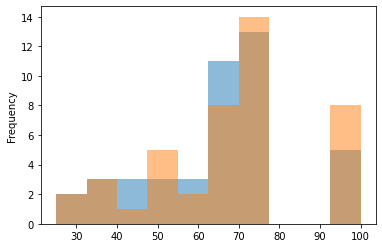

In [11]:
pd.DataFrame(similarity_info).T['cde_cs_prec'].plot.hist(alpha=0.5)
pd.DataFrame(similarity_info).T['gpt_cs_prec'].plot.hist(alpha=0.5)
pd.DataFrame(similarity_info).T['cde_cs_prec'].describe()

In [12]:
source_dir = Path(r"D:/NIST-ZIF-8")

test_paragraph = SynParagraph(paper_identifier='s10450-012-9407-1.18', source_directory=source_dir)
test_sequence = Sequence(test_paragraph.raw_synthesis)
test_sequence.drop_invalid_lines()
test_sequence.clean_synthesis

textdistance.lcsstr.normalized_distance(list(manual_data[manual_data['Paper']=='s10450-012-9407-1.18']['name']),
                                             list(test_sequence.clean_synthesis['name']))
# SequenceMatcher(a=list(manual_data[manual_data['Paper']=='s10450-012-9407-1.18']['Step type']),
#                 b=list(test_sequence.clean_synthesis['name'])).find_longest_match(
#         0,len(list(manual_data[manual_data['Paper']=='s10450-012-9407-1.18']['Step type'])),
#     0, len(list(test_sequence.clean_synthesis['name'])))
list(manual_data[manual_data['Paper']=='s10450-012-9407-1.18']['name'])[4:7]

NameError: name 'Sequence' is not defined

In [ ]:
thing = test_sequence.extract_times_and_temps()
print(test_sequence.time_temp['T (K)'].dropna().tolist())
print(test_sequence.time_temp['Time (min)'].dropna().sum())

In [ ]:
source_dir = Path(r"C:\Users\d23895jm\OneDrive - The University of Manchester\Sarkisov Group\Research\Individual Directories\Joe Manning\SynOracle Development\NIST-ZIF-8")

lcsstr_similarities = []

lev_similarities = []
needleman_similarities = []
length_difference = []

vocab=set()
vocab2 = set()

for x in paper_indices:
    test_paragraph = SynParagraph(paper_identifier=x, source_directory=source_dir)
    test_sequence = Sequence(test_paragraph.raw_synthesis)
    test_sequence.drop_invalid_lines()
    test_sequence.clean_synthesis
    thing = test_sequence.extract_times_and_temps()
    try:
        print(test_sequence.time_temp['T (K)'].dropna().tolist())
    except KeyError:
        pass
    try:
        print(test_sequence.time_temp['Time (min)'].dropna().sum())
    except KeyError:
        pass
    
    manual_sequence = list(manual_data[manual_data['Paper']==x]['name'])
    parsed_sequence = list(test_sequence.clean_synthesis['name'])
    for y in parsed_sequence:
        vocab.add(y)
    for z in manual_sequence:
        vocab2.add(z)
    lev_similarities.append(textdistance.levenshtein.normalized_distance(manual_sequence, parsed_sequence))
    print(textdistance.gotoh.normalized_distance(manual_sequence, parsed_sequence))
    needleman_similarities.append(textdistance.needleman_wunsch.normalized_distance(manual_sequence, parsed_sequence))
    lcsstr_similarities.append(textdistance.lcsstr.normalized_distance(manual_sequence, parsed_sequence))

    print(manual_sequence)
    print(parsed_sequence)
    length_difference.append(abs(len(manual_sequence)-len(parsed_sequence)))

In [ ]:
plt.hist(lev_similarities, alpha=0.5)
plt.xlabel('Relative distance (0 = identical)')
plt.ylabel('Count')
plt.title('Normalised Levenshtein distance')#plt.hist(needleman_similarities)

In [ ]:
plt.hist(length_difference)
plt.xlabel('Number of actions')
plt.ylabel('Count')
plt.title('Absolute difference in sequence length')

In [ ]:
vocab

In [ ]:
type_subs = {
'add': ['Add', 'Dissolve'],
'del': ['Extract', 'Filter', 'Partition', 'Precipitate', 'Purify', 'Recover', 'Remove', 'Yield'],
'trans': ['ApparatusAction', 'Cool', 'Degass', 'Dry', 'Heat', 'Stir', 'Synthesize', 'Wait', 'Wash']}

type_subs = {
    'Add': 'add',
    'Dissolve': 'add',
    
    'Extract': 'del',
    'Filter': 'del',
    'Partition': 'del',
    'Partiton': 'del',

    'partition': 'del',
    'Precipitate': 'del',
    'Purify': 'del',
    'Recover': 'del',
    'Remove': 'del',
    'Yield': 'del',
    'ApparatusAction': 'trans',
    'Cool': 'trans',
    'Degass': 'trans',
    'Dry': 'trans',
    'dry': 'trans',

    'Heat': 'trans',
    'Stir': 'trans',
    'Synthesize': 'trans',
    'synthesize': 'trans',

    'Wait': 'trans',
    'wait': 'trans',

    'Wash': 'trans',
    'wash': 'trans',
    'Seal': 'trans',
    'Evacuate': 'trans',
    'Mix': 'add',
    'Suspend': 'add',
    'Pelletize': 'trans'
    
}

In [ ]:
from difflib import SequenceMatcher
lev_similarities = []
needleman_similarities = []
lcsstr_similarities = []

for x in paper_indices:
    test_paragraph = SynParagraph(paper_identifier=x, source_directory=source_dir)
    test_sequence = Sequence(test_paragraph.raw_synthesis)
    test_sequence.drop_invalid_lines()
    test_sequence.clean_synthesis
    
    manual_sequence = list(manual_data[manual_data['Paper']==x]['name'])
    parsed_sequence = list(test_sequence.clean_synthesis['name'])
    print(parsed_sequence)
    manual_remapped = []
    for y in manual_sequence:
        try:
            manual_remapped.append(type_subs[y])
        except KeyError:
            print('\tfailed to subsitute: ', y)
            continue
    parsed_remapped = []
    for y in parsed_sequence:
        try:
            parsed_remapped.append(type_subs[y])
        except KeyError:
            print('\tfailed to subsitute: ', y)
            continue
    print(manual_remapped)
    print(parsed_remapped)
    match = SequenceMatcher(a=manual_remapped, b=parsed_remapped).find_longest_match(
        0,len(manual_remapped), 0, len(parsed_remapped))
    print(match.size)
    print(manual_remapped[match.a: match.a+match.size])
    print(parsed_remapped[match.b: match.b+match.size])
    lcsstr_similarities.append(textdistance.lcsstr.normalized_distance(manual_remapped, parsed_remapped))
    lev_similarities.append(textdistance.levenshtein.normalized_distance(manual_remapped, parsed_remapped))
    needleman_similarities.append(textdistance.needleman_wunsch.normalized_distance(manual_remapped, parsed_remapped))

#plt.hist(lev_similarities, alpha=0.5)
#plt.hist(needleman_similarities, alpha=0.5)
plt.hist(lcsstr_similarities, alpha=0.5)

In [ ]:
dir(SequenceMatcher)

In [ ]:
source_dir = Path(r"C:\Users\d23895jm\OneDrive - The University of Manchester\Sarkisov Group\Research\Individual Directories\Joe Manning\SynOracle Development\NIST-ZIF-8")



for x in paper_indices:
    print(x)
    print('parsed')
    test_paragraph = SynParagraph(paper_identifier=x, source_directory=source_dir)
    test_sequence = Sequence(test_paragraph.raw_synthesis)
    test_sequence.drop_invalid_lines()
    test_sequence.clean_synthesis
    test_sequence.extract_times_and_temps()
    try:
        print(test_sequence.time_temp['T (K)'].dropna().tolist())
    except KeyError:
        pass
    try:
        print(test_sequence.time_temp['Time (min)'].dropna().sum())
    except KeyError:
        pass
    print('manual')
    manual_sequence = Sequence(manual_data[manual_data['Paper']==x])
    
    manual_sequence.drop_invalid_lines()
    #print(manual_sequence.clean_synthesis)
    manual_sequence.extract_times_and_temps()
    try:
        print(manual_sequence.time_temp['T (K)'].dropna().tolist())
    except KeyError:
        pass
    try:
        print(manual_sequence.time_temp['Time (min)'].dropna().sum())
    except KeyError:
        pass    
    